In [168]:
# import library
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs,make_moons,make_swiss_roll

plt.style.use('seaborn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

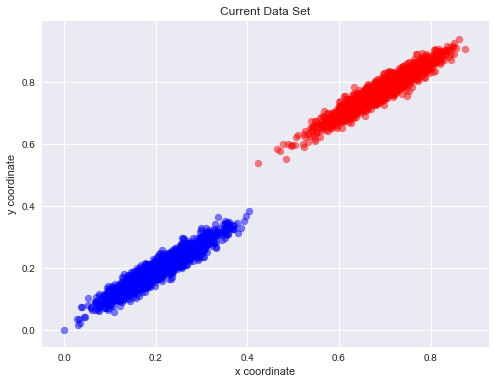

In [169]:
# load some data set
n_samples = 4000
X, y = make_blobs(n_samples=n_samples, random_state=123)
transformation = np.asarray([
    [3,1],
    [1,0]
])
X = X @ transformation
X = (X - X.min(0,keepdims=True)) / (X.max(0,keepdims=True) - X.min(0,keepdims=True))
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('Current Data Set'); plt.ylabel('y coordinate'); plt.xlabel('x coordinate'); plt.grid(True)
plt.show()

[1 0]


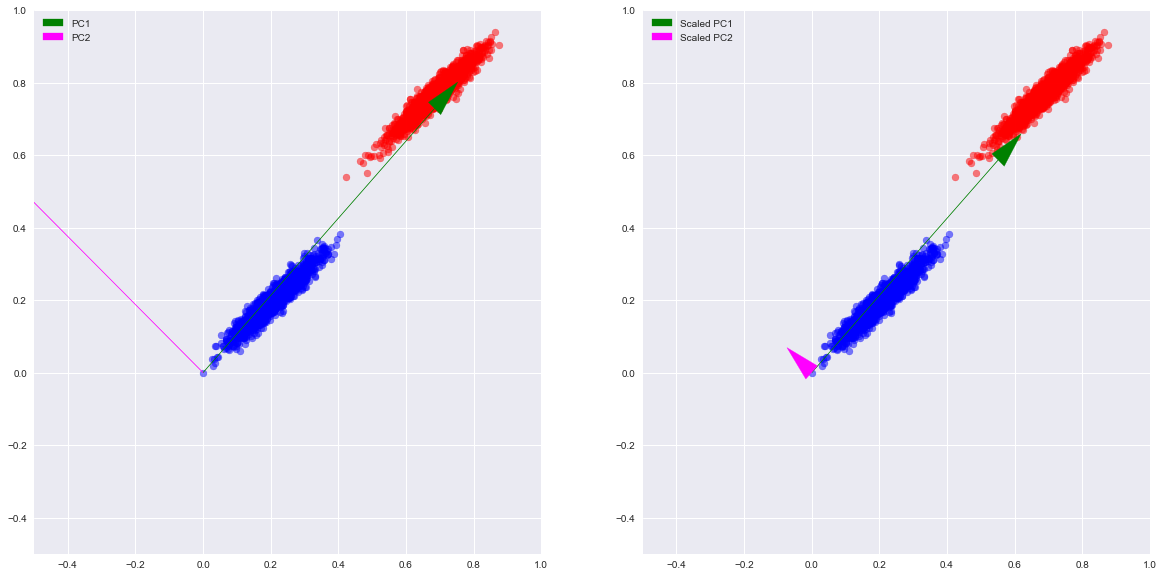

In [196]:
# Do EVD to see the projection matrix
X_cen      = X - X.mean(0,keepdims=True)
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)

idx        = np.argsort(val)[::-1]
val        = val[idx]; vec = vec[:,idx]

plt.figure(figsize=(20,10)); 
plt.subplot(121); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] , head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] , head_width=0.05, head_length=0.1,color='magenta',label='Second PC')
plt.grid(True); plt.xlim(-.5,1); plt.ylim(-.5,1)
plt.legend([pca11,pca12],['PC1','PC2']);

plt.subplot(122); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.1,color='magenta',label='Second PC')
plt.grid(True); plt.xlim(-.5,1); plt.ylim(-.5,1)

plt.legend([pca21,pca22],['Scaled PC1','Scaled PC2']);plt.show()

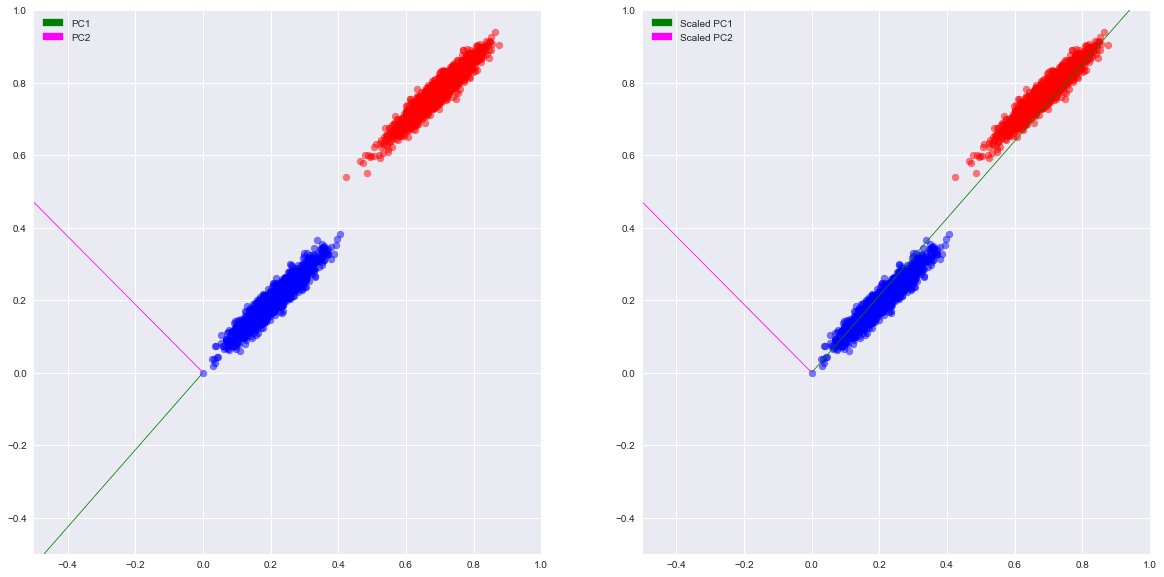

In [202]:
# Do SVD 
U,Sigma,VT = np.linalg.svd(X)

plt.figure(figsize=(20,10)); 
plt.subplot(121); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *VT[:,0] , head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *VT[:,1] , head_width=0.05, head_length=0.1,color='magenta',label='Second PC')
plt.grid(True); plt.xlim(-.5,1); plt.ylim(-.5,1)
plt.legend([pca11,pca12],['PC1','PC2']);

plt.subplot(122); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *VT[:,0] * -Sigma[0], head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *VT[:,1] * Sigma[1], head_width=0.05, head_length=0.1,color='magenta',label='Second PC')
plt.grid(True); plt.xlim(-.5,1); plt.ylim(-.5,1)

plt.legend([pca21,pca22],['Scaled PC1','Scaled PC2']);plt.show()

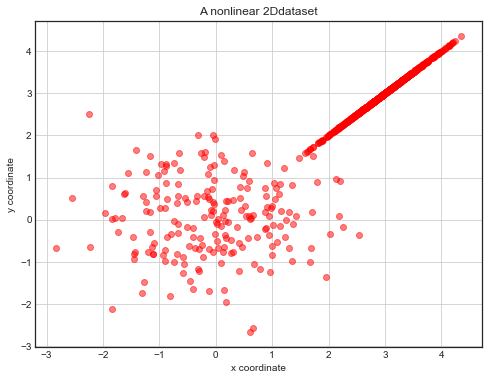

-2.8345545052747023


In [71]:
# try the KPCA on a smaller dimension dataset
from sklearn.datasets import make_moons,make_regression
# X, y   = make_moons     (n_samples=2000, random_state=123,noise =0.0)
n_samples = 1000
n_outliers = 800


X, y, coef = make_regression(n_samples=n_samples, n_features=2,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)



plt.figure(figsize=(8,6))
# plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
# plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], color='red',  alpha=0.5)
plt.title('A nonlinear 2Ddataset'); plt.ylabel('y coordinate'); plt.xlabel('x coordinate')
plt.grid(True)
plt.show()
print(X[:,0].min())

(1000, 1000) (2,) (2, 2)


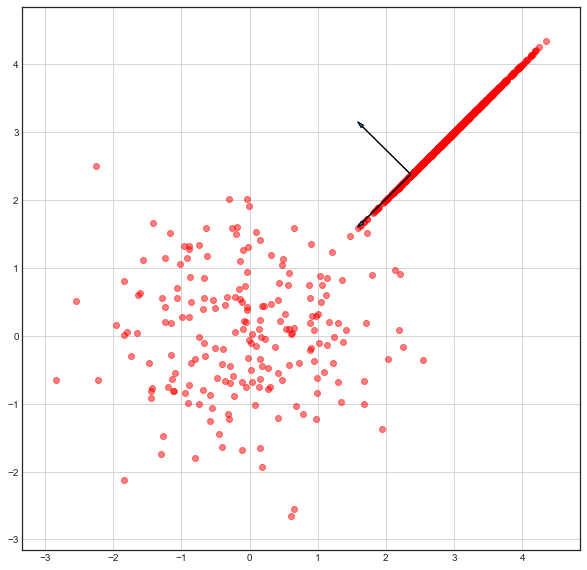

In [73]:
# Perform SVD on numpy and projection
U,Sigma,VT = np.linalg.svd(X,full_matrices=True)
print(U.shape,Sigma.shape,VT.shape)

plt.figure(figsize=(10,10)); ax = plt.axes()

# plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
# plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], color='red',  alpha=0.5)

ax.arrow   (X[:,0].mean(), X[:,1].mean(), *VT[:,0], head_width=0.05, head_length=0.1)
ax.arrow   (X[:,0].mean(), X[:,1].mean(), *VT[:,1], head_width=0.05, head_length=0.1)

plt.grid(True); plt.xlim(X[:,0].min()-0.5,X[:,0].max()+0.5);plt.ylim(X[:,1].min()-0.5,X[:,1].max()+0.5);plt.show()

(2, 2)
(2,)


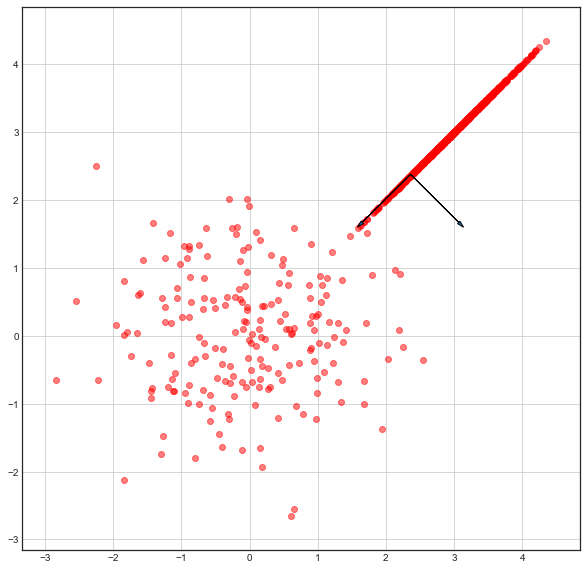

In [74]:
temp = X.T @ X /(X.shape[1]-1)
print(temp.shape)
val,vec = np.linalg.eigh(temp)
print(val.shape)

plt.figure(figsize=(10,10)); ax = plt.axes()

# plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
# plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], color='red',  alpha=0.5)

ax.arrow   (X[:,0].mean(), X[:,1].mean(), *vec[:,0], head_width=0.05, head_length=0.1)
ax.arrow   (X[:,0].mean(), X[:,1].mean(), *vec[:,1], head_width=0.05, head_length=0.1)

plt.grid(True); plt.xlim(X[:,0].min()-0.5,X[:,0].max()+0.5);plt.ylim(X[:,1].min()-0.5,X[:,1].max()+0.5);plt.show()

# Reference
1. tf.set_random_seed | TensorFlow. (2018). TensorFlow. Retrieved 28 October 2018, from https://www.tensorflow.org/api_docs/python/tf/set_random_seed
2. Comparing different hierarchical linkage methods on toy datasets — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py
3. VanderPlas, J. (2018). Multiple Subplots | Python Data Science Handbook. Jakevdp.github.io. Retrieved 28 October 2018, from https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
4. object, M. (2018). Matplotlib returning a plot object. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/43925337/matplotlib-returning-a-plot-object
5. Plot randomly generated classification dataset — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html#sphx-glr-auto-examples-datasets-plot-random-dataset-py
6. 5. Dataset loading utilities — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/datasets/index.html
7. mplot3d tutorial — Matplotlib 2.0.2 documentation. (2018). Matplotlib.org. Retrieved 28 October 2018, from https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
8. matplotlib, H. (2018). How to plot vectors in python using matplotlib. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/42281966/how-to-plot-vectors-in-python-using-matplotlib
9. arrow, M. (2018). Matplotlib legend for an arrow. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/22348229/matplotlib-legend-for-an-arrow
10. plt colors - Google Search. (2018). Google.ca. Retrieved 28 October 2018, from https://www.google.ca/search?q=plt+colors&rlz=1C1CHBF_enCA771CA771&oq=plt+colors&aqs=chrome..69i57j0l5.1038j0j7&sourceid=chrome&ie=UTF-8
11. 